# **2024-01-18** N-Queens with VQA

## 1 Idea

## 2 Code

In [1]:
import pennylane as qml
import numpy as np
import torch
from torch import optim
from collections import defaultdict
import networkx as nx
import copy
import math
from itertools import combinations
import sys

### Functions

### Using Chess Class

In [186]:
class Chess:
  def __init__(self, size = 4, horses = []):
    '''
      Args :
        size(int) : size of Chess Board
        horses(list[list[int]]) : indexes(row, col) of placed horses, Not Duplicated with Same Row or Column
    '''
    is_nonempty = defaultdict(int)
    self.board = [[0 for _ in range(size)] for _ in range(size)]
    self.horses = horses
    self.size = size
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def set_horses(self, new_horses):
    self.horses = self.horses + new_horses
    horses = self.horses
    size = self.size
    is_nonempty = defaultdict(int)
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def draw(self):
    boxes = ['□', '◆']
    for row_board in self.board:
      for b in row_board:
        print(boxes[b], end ='')
      print()



### Settings

In [187]:
## Make Chess Board ##
C1 = Chess(4, [[0, 1]])
C1.draw()
C1.empty_rows, C1.nonempty_rows

□◆□□
□□□□
□□□□
□□□□


([1, 2, 3], [0])

In [226]:
## Prepare to ML ##
board_size = C1.size
n = board_size
empty_rows = C1.empty_rows
required_weights = 3 * int(np.ceil(np.log2(board_size))) * len(empty_rows) # 3 : Rx,Ry,Rz, (np.ceil(np.log2(board_size))) : 한 row를 표현하는 qubit 개수, len(empty_rows) : 필요한 행의 개수
required_for_row = int(np.ceil(np.log2(n)))
required_wires = len(empty_rows) * required_for_row # int(np.ceil(np.log2(n)))
num_of_layers = 1

## Prepare to Quantum Device ##
dev = qml.device("default.qubit", wires = required_wires) #device 설정
w = torch.tensor(torch.rand(num_of_layers * required_weights) * 2 * np.pi, requires_grad = True)
N_iter = 300

### print for test ##|
print('n :', n)
print('num of w :', len(w))
print(w.detach().numpy())
print(np.shape(w.detach().numpy()))
print(empty_rows)

n : 4
num of w : 18
[6.0184603  2.3217878  5.498201   6.277238   1.6343832  6.271435
 5.0609813  0.7887837  4.1552715  0.39100745 1.5483238  5.9640965
 1.237894   0.93180084 3.5309272  5.8043256  0.89759785 4.748744  ]
(18,)
[1, 2, 3]


C:\Users\wlsgu\AppData\Local\Temp\ipykernel_18648\853505902.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(torch.rand(num_of_layers * required_weights) * 2 * np.pi, requires_grad = True)


### Quantum Circuit

In [227]:
#VQA Layer(Ansatz) building
def vqa_layer(thetas = w, size = board_size, empty_rows = empty_rows, n_layer = num_of_layers): #Ansatz
    th_count = 0
    n = board_size
    for i in range(n_layer):
      for j in range(required_wires):
        qml.RX(thetas[th_count], j)
        th_count += 1
        qml.RY(thetas[th_count], j)
        th_count += 1
        qml.RZ(thetas[th_count], j)
        th_count += 1
      for j in range(required_wires):
        qml.CNOT([j, (j+1) % required_wires])

In [228]:
#get state vector
@qml.qnode(dev, interface = 'torch')
def state_vec(thetas = w, board = C1, n_layer = num_of_layers):
  vqa_layer() #Ansatz Apply
  return qml.probs()

In [229]:
@qml.qnode(dev, interface='torch')
def main_circuit(thetas = w, board = C1, n_layer = num_of_layers):
  vqa_layer() #Ansatz Apply
  m_result = [qml.expval(qml.PauliZ(i)) for i in range(required_wires)]
  return m_result

main_circuit_result = main_circuit(thetas = w, board = C1, n_layer = num_of_layers)
main_circuit_result

[tensor(-3.4273e-05, dtype=torch.float64, grad_fn=<DotBackward0>),
 tensor(0.0418, dtype=torch.float64, grad_fn=<DotBackward0>),
 tensor(0.0101, dtype=torch.float64, grad_fn=<DotBackward0>),
 tensor(0.0002, dtype=torch.float64, grad_fn=<DotBackward0>),
 tensor(4.0770e-05, dtype=torch.float64, grad_fn=<DotBackward0>),
 tensor(2.2531e-05, dtype=torch.float64, grad_fn=<DotBackward0>)]

### cost function

In [230]:
def name1(main_circuit_result ):
    prepared_result = torch.stack(main_circuit_result, dim=0).reshape(-1,2)/2+.5
    prepare = torch.tensor(C1.board[0])
    for a,b in prepared_result:
        prepare = torch.vstack((prepare , torch.stack([ torch.abs((1-a)*(1-b)), torch.abs((1-a)*b), torch.abs(a*(1-b)), torch.abs(a*b)])))
    return prepare

name1(main_circuit_result)

tensor([[0.0000, 1.0000, 0.0000, 0.0000],
        [0.2395, 0.2605, 0.2395, 0.2605],
        [0.2474, 0.2475, 0.2525, 0.2526],
        [0.2500, 0.2500, 0.2500, 0.2500]], dtype=torch.float64,
       grad_fn=<CatBackward0>)

In [231]:
size =4
def cost_fn(main_circuit_result, empty_rows):
    
    ham = 0

    result = name1(main_circuit_result )

    for i in empty_rows:
        ham += (torch.sum(result[i])-1)*(torch.sum(result[i])-1)
    for i in range(size):
        ham += (torch.sum(result.T[i])-1)*(torch.sum(result.T[i])-1)


    for i in range(2*size-3): # 대각선 개수 2*size -1 -2(대각선 요소 1개인 것)
        diag1 = torch.diagonal(result,i-2)
        diag2 = torch.diagonal(torch.flip(result,[-1]),i-2)
        ham += torch.abs((torch.sum(diag1))*(torch.sum(diag1)-1))
        ham += torch.abs((torch.sum(diag2))*(torch.sum(diag2)-1))
    return ham

cost_fn(main_circuit_result, empty_rows)

tensor(3.4895, dtype=torch.float64, grad_fn=<AddBackward0>)

### optimizing

In [232]:
# start optimizing weights
optimizer = optim.Adam([w],lr=0.1)

loss = []
for it in range(N_iter):
    cost = cost_fn(main_circuit(thetas = w, board = C1, n_layer = num_of_layers), empty_rows)
    loss.append(float(cost))
    optimizer.zero_grad() 
    cost.backward() 
    optimizer.step() 
    print('iteration number : ', it,' cost is ', cost)

iteration number :  0  cost is  tensor(3.4895, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  1  cost is  tensor(3.4642, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  2  cost is  tensor(3.4212, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  3  cost is  tensor(3.3509, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  4  cost is  tensor(3.2388, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  5  cost is  tensor(3.0686, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  6  cost is  tensor(3.1133, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  7  cost is  tensor(3.1466, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  8  cost is  tensor(3.1277, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  9  cost is  tensor(3.0658, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  10  cost is  tensor(2.9795, dtype=torch.float64, grad_fn=<Ad

### Loss

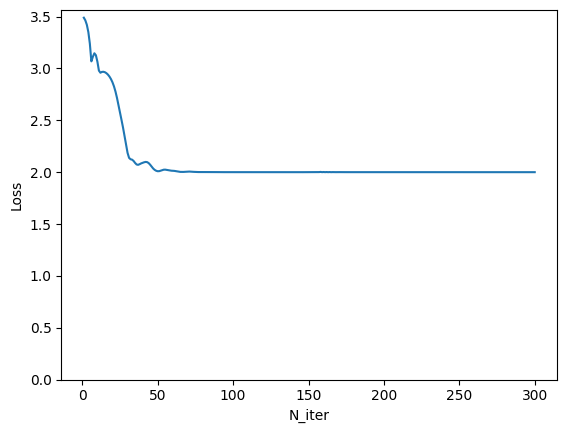

In [233]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,N_iter+1),loss)
plt.xlabel('N_iter')
plt.ylabel('Loss')
plt.ylim(0)
plt.show()

## 현 상황

In [234]:
# after optimization
main_circuit_result = main_circuit(thetas = w, board = C1, n_layer = num_of_layers)
print(name1(main_circuit_result))

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.7418e-14, 6.7131e-07, 1.1532e-07, 1.0000e+00],
        [5.0681e-07, 3.3956e-13, 1.0000e+00, 6.6998e-07],
        [1.0000e+00, 6.7475e-07, 6.6998e-07, 4.5207e-13]], dtype=torch.float64,
       grad_fn=<CatBackward0>)


- local minimun에서 못 벗어남

### Result check

In [87]:
result_state = probs_to_str()
print(result_state)
result_index = str_to_indexes(result_state) + [c[0] * n + c[1] for c in C1.horses]
print(result_index)
result_horses = [[e // n, e % n] for e in result_index]
C2 = Chess(4, result_horses)

print(classical_cost_f(result_index))

print(result_horses)
C2.draw()

010101
[5, 9, 13, 1]
tensor(12., requires_grad=True)
[[1, 1], [2, 1], [3, 1], [0, 1]]
□◆□□
□◆□□
□◆□□
□◆□□


In [18]:
# expect_E = main_circuit(w,C1,num_of_layers)#.item()
m_result = list(main_circuit())
M_index = m_result.index(max(m_result))
bit_string = bin(M_index)[2:]

state_f = state_vec()
ans=0

expect_E = my_cost()
print("expectation value(loss) of energy : ", expect_E)
print('result :', bit_string)
result = [bit_string]

[tensor(0.0169, grad_fn=<UnbindBackward0>), tensor(0.0044, grad_fn=<UnbindBackward0>), tensor(0.0102, grad_fn=<UnbindBackward0>), tensor(0.0007, grad_fn=<UnbindBackward0>), tensor(0.0264, grad_fn=<UnbindBackward0>), tensor(0.0163, grad_fn=<UnbindBackward0>), tensor(0.0280, grad_fn=<UnbindBackward0>), tensor(0.0059, grad_fn=<UnbindBackward0>), tensor(0.0022, grad_fn=<UnbindBackward0>), tensor(0.0114, grad_fn=<UnbindBackward0>), tensor(0.0660, grad_fn=<UnbindBackward0>), tensor(0.0129, grad_fn=<UnbindBackward0>), tensor(0.0084, grad_fn=<UnbindBackward0>), tensor(0.0016, grad_fn=<UnbindBackward0>), tensor(0.0360, grad_fn=<UnbindBackward0>), tensor(0.0047, grad_fn=<UnbindBackward0>), tensor(0.0090, grad_fn=<UnbindBackward0>), tensor(0.0556, grad_fn=<UnbindBackward0>), tensor(0.0010, grad_fn=<UnbindBackward0>), tensor(0.0009, grad_fn=<UnbindBackward0>), tensor(0.0161, grad_fn=<UnbindBackward0>), tensor(0.1039, grad_fn=<UnbindBackward0>), tensor(0.0010, grad_fn=<UnbindBackward0>), tensor(0.0

In [17]:
'''
for i in range(2 ** (board_size * board_size)):
    print(f"probability of getting |{i}> :",abs(state_f[i])**2)
'''
for i in range(2 ** (board_size * board_size)):
    if abs(state_f[i]) ** 2 > 0.1:
        result.append((bin(i)[2:], abs(state_f[i].item())**2))
        print(format(i,'b')+"is ground state with probability",abs(state_f[i].item())**2)


IndexError: index 64 is out of bounds for dimension 0 with size 64

(<Figure size 600x700 with 1 Axes>, <Axes: >)


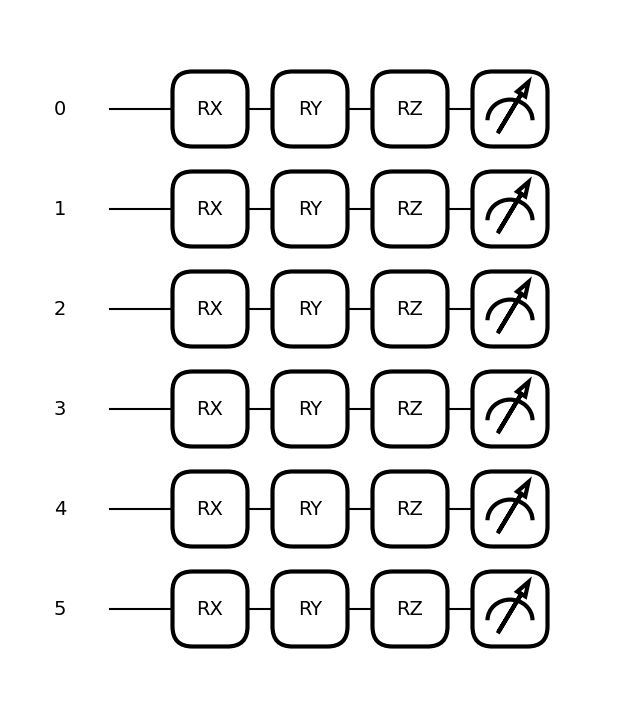

In [208]:
print(qml.draw_mpl(state_vec)())

### Circuit check

## Result Chk

In [ ]:
result.sort(key = lambda x:x[1])
result = result [::-1]
print(result)

[('100001000011000', 0.6200044296810338), ('100001000010001', 0.2062962210384992)]


In [ ]:
def answer(result : dict):
    n = C1.size
    for e in result:
      print('===========================')
      ans = int(e)#[0])
      coordinates = []
      cnt = n * n - 1
      while cnt >= 0:
        if ans % 10 == 1:
          coordinates.append([cnt // n, cnt % n])
        cnt -= 1
        ans //= 10
      tempC = Chess(n, coordinates)
      tempC.draw()
      print('===========================')

    '''
    for ans in result:
      temp_board  = [[0 for _ in range(n) for _ in range(n)]]
      cnt = n ** 2 - 1
      while cnt > 0:
        i, j = cnt // n, cnt % n
        temp_board[i][j] = ans % 10
        ans //= 10
        cnt -= 1
    '''
    return

answer(result)

□◆□□
□□◆□
◆□□□
□□◆□
